In [1]:
#Basic libraries
import pandas as pd 
import numpy as np 


#NLTK libraries
import nltk
import re
import string
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning libraries
import sklearn 
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn import svm, datasets
from sklearn import preprocessing 


#Metrics libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

#Visualization libraries
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Other miscellaneous libraries
from numpy import interp
from itertools import cycle
import cufflinks as cf
from collections import defaultdict
from collections import Counter
from imblearn.over_sampling import BorderlineSMOTE

In [3]:
raw_reviews = pd.read_csv('C:\\Users\\KIIT\\Downloads\\output.csv')
## print shape of dataset with rows and columns and information 
print ("The shape of the  data is (row, column):"+ str(raw_reviews.shape))
print (raw_reviews.info())

The shape of the  data is (row, column):(1696, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1696 entries, 0 to 1695
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         1696 non-null   object 
 1   Stars        1557 non-null   float64
 2   Title        1696 non-null   object 
 3   Date         1696 non-null   object 
 4   Description  1689 non-null   object 
dtypes: float64(1), object(4)
memory usage: 66.4+ KB
None


In [4]:
raw_reviews.head()

Name  Stars                                              Title  \
0  Aidan Shane Wade    5.0                     5.0 out of 5 stars\nVery fast!   
1      Rich and Jen    5.0    5.0 out of 5 stars\nShe's a beast, but so HOT!!   
2      Amazon lover    5.0  5.0 out of 5 stars\nRunning air cooled on Deep...   
3           Eric E.    5.0  5.0 out of 5 stars\nMuch faster than my previo...   
4             Rdawg    5.0              5.0 out of 5 stars\nPowerful but Warm   

         Date                                        Description  
0  05-07-2024  Its very capable for modern gaming without di...  
1  03-01-2024  I guess everyone is right, these things are ho...  
2  03-11-2023  So far so good.  This CPU is a monster and run...  
3  19-03-2024  So I finally upgraded my home workstation, and...  
4  08-05-2024  Before you purchase this CPU please also purch...

In [5]:
#Creating a copy
process_reviews=raw_reviews.copy()

#Checking for null values
process_reviews.isnull().sum()

Name             0
Stars          139
Title            0
Date             0
Description      7
dtype: int64

In [6]:
process_reviews['Date']=process_reviews['Date'].fillna('Missing')

In [7]:
process_reviews['reviews']=process_reviews['Title']+" "+process_reviews['Description']
process_reviews=process_reviews.drop(['Description', 'Title'], axis=1)
process_reviews.head()

Name  Stars        Date  \
0  Aidan Shane Wade    5.0  05-07-2024   
1      Rich and Jen    5.0  03-01-2024   
2      Amazon lover    5.0  03-11-2023   
3           Eric E.    5.0  19-03-2024   
4             Rdawg    5.0  08-05-2024   

                                             reviews  
0  5.0 out of 5 stars\nVery fast! Its very capab...  
1  5.0 out of 5 stars\nShe's a beast, but so HOT!...  
2  5.0 out of 5 stars\nRunning air cooled on Deep...  
3  5.0 out of 5 stars\nMuch faster than my previo...  
4  5.0 out of 5 stars\nPowerful but Warm Before y...

In [8]:
#Figuring out the distribution of categories
process_reviews['Stars'].value_counts()

Stars
5.0    1289
4.0     166
3.0      44
1.0      44
2.0      14
Name: count, dtype: int64

In [9]:
def f(row):
    
    '''This function returns sentiment value based on the Stars ratings from the user'''
    
    if row['Stars'] == 3.0:
        val = 'Neutral'
    elif row['Stars'] == 1.0 or row['Stars'] == 2.0:
        val = 'Negative'
    elif row['Stars'] == 4.0 or row['Stars'] == 5.0:
        val = 'Positive'
    else:
        val = 'None'
    return val

In [10]:
#Applying the function in our new column
process_reviews['Sentiment'] = process_reviews.apply(f, axis=1)
process_reviews.head()

Name  Stars        Date  \
0  Aidan Shane Wade    5.0  05-07-2024   
1      Rich and Jen    5.0  03-01-2024   
2      Amazon lover    5.0  03-11-2023   
3           Eric E.    5.0  19-03-2024   
4             Rdawg    5.0  08-05-2024   

                                             reviews Sentiment  
0  5.0 out of 5 stars\nVery fast! Its very capab...  Positive  
1  5.0 out of 5 stars\nShe's a beast, but so HOT!...  Positive  
2  5.0 out of 5 stars\nRunning air cooled on Deep...  Positive  
3  5.0 out of 5 stars\nMuch faster than my previo...  Positive  
4  5.0 out of 5 stars\nPowerful but Warm Before y...  Positive

In [11]:
process_reviews['Sentiment'].value_counts()

Sentiment
Positive    1455
None         139
Negative      58
Neutral       44
Name: count, dtype: int64

In [12]:
#Removing unnecessary columns
process_reviews=process_reviews.drop(['Date'], axis=1)
#Creating a copy 
clean_reviews=process_reviews.copy()

In [13]:
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [14]:
process_reviews['reviews']=process_reviews['reviews'].apply(lambda x:review_cleaning(x))
process_reviews.head()

Name  Stars                                            reviews  \
0  Aidan Shane Wade    5.0   out of  starsvery fast its very capable for ...   
1      Rich and Jen    5.0   out of  starsshes a beast but so hot i guess ...   
2      Amazon lover    5.0   out of  starsrunning air cooled on deepcool a...   
3           Eric E.    5.0   out of  starsmuch faster than my previous  so...   
4             Rdawg    5.0   out of  starspowerful but warm before you pur...   

  Sentiment  
0  Positive  
1  Positive  
2  Positive  
3  Positive  
4  Positive

In [15]:
stop_words= ['yourselves', 'between', 'whom', 'itself', 'is', "she's", 'up', 'herself', 'here', 'your', 'each', 
             'we', 'he', 'my', "you've", 'having', 'in', 'both', 'for', 'themselves', 'are', 'them', 'other',
             'and', 'an', 'during', 'their', 'can', 'yourself', 'she', 'until', 'so', 'these', 'ours', 'above', 
             'what', 'while', 'have', 're', 'more', 'only', "needn't", 'when', 'just', 'that', 'were', "don't", 
             'very', 'should', 'any', 'y', 'isn', 'who',  'a', 'they', 'to', 'too', "should've", 'has', 'before',
             'into', 'yours', "it's", 'do', 'against', 'on',  'now', 'her', 've', 'd', 'by', 'am', 'from', 
             'about', 'further', "that'll", "you'd", 'you', 'as', 'how', 'been', 'the', 'or', 'doing', 'such',
             'his', 'himself', 'ourselves',  'was', 'through', 'out', 'below', 'own', 'myself', 'theirs', 
             'me', 'why', 'once',  'him', 'than', 'be', 'most', "you'll", 'same', 'some', 'with', 'few', 'it',
             'at', 'after', 'its', 'which', 'there','our', 'this', 'hers', 'being', 'did', 'of', 'had', 'under',
             'over','again', 'where', 'those', 'then', "you're", 'i', 'because', 'does', 'all']

In [16]:
process_reviews['reviews'] = process_reviews['reviews'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
process_reviews.head()

Name  Stars                                            reviews  \
0  Aidan Shane Wade    5.0  starsvery fast its capable modern gaming with...   
1      Rich and Jen    5.0  starsshes beast but hot guess everyone right t...   
2      Amazon lover    5.0  starsrunning air cooled deepcool assassin iv e...   
3           Eric E.    5.0  starsmuch faster previous finally upgraded hom...   
4             Rdawg    5.0  starspowerful but warm purchase cpu please als...   

  Sentiment  
0  Positive  
1  Positive  
2  Positive  
3  Positive  
4  Positive

In [17]:
pd.DataFrame(process_reviews)

Name  Stars  \
0                       Aidan Shane Wade    5.0   
1                           Rich and Jen    5.0   
2                           Amazon lover    5.0   
3                                Eric E.    5.0   
4                                  Rdawg    5.0   
...                                  ...    ...   
1691                       Consumer Bias    5.0   
1692                       Curtis Lysher    5.0   
1693  Carlos Alberto HernÃ¡ndez Mosquera    5.0   
1694                              Joseph    5.0   
1695                             Anthony    NaN   

                                                reviews Sentiment  
0     starsvery fast its capable modern gaming with...  Positive  
1     starsshes beast but hot guess everyone right t...  Positive  
2     starsrunning air cooled deepcool assassin iv e...  Positive  
3     starsmuch faster previous finally upgraded hom...  Positive  
4     starspowerful but warm purchase cpu please als...  Positive  
...                                                 ...       ...  
1691  core easy overclock intel xtu software set cor...  Positive  
1692  starsfast processor time bit outdated but stil...  Positive  
1693  starsmuy buen procesador excelente desempeã±o ...  Positive  
1694  starseasy install works well high expectations...  Positive  
1695  product us good but took extra days deliver sj...      None  

[1696 rows x 4 columns]

In [18]:
process_reviews['polarity'] = process_reviews['reviews'].map(lambda text: TextBlob(text).sentiment.polarity)
process_reviews['review_len'] = process_reviews['reviews'].astype(str).apply(len)
process_reviews['word_count'] = process_reviews['reviews'].apply(lambda x: len(str(x).split()))

In [19]:
process_reviews.head()

Name  Stars                                            reviews  \
0  Aidan Shane Wade    5.0  starsvery fast its capable modern gaming with...   
1      Rich and Jen    5.0  starsshes beast but hot guess everyone right t...   
2      Amazon lover    5.0  starsrunning air cooled deepcool assassin iv e...   
3           Eric E.    5.0  starsmuch faster previous finally upgraded hom...   
4             Rdawg    5.0  starspowerful but warm purchase cpu please als...   

  Sentiment  polarity  review_len  word_count  
0  Positive  0.243939         265          41  
1  Positive  0.279089         774         135  
2  Positive  0.164825        1335         203  
3  Positive  0.104658        1334         212  
4  Positive  0.288889         475          72

In [20]:
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

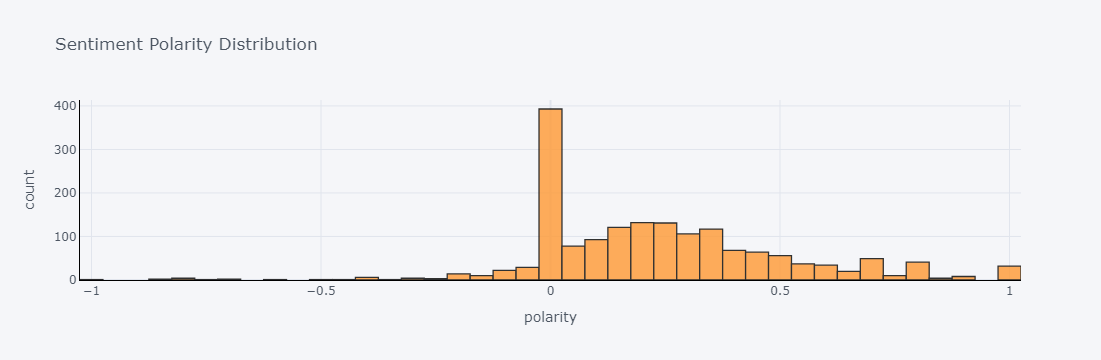

In [21]:
process_reviews['polarity'].iplot(
    kind='hist',
    bins=50,
    xTitle='polarity',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution')

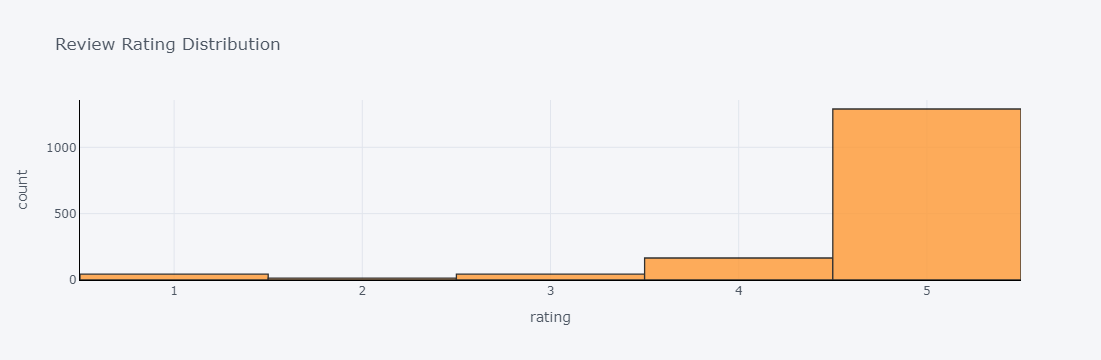

In [22]:
process_reviews['Stars'].iplot(
    kind='hist',
    xTitle='rating',
    linecolor='black',
    yTitle='count',
    title='Review Rating Distribution')

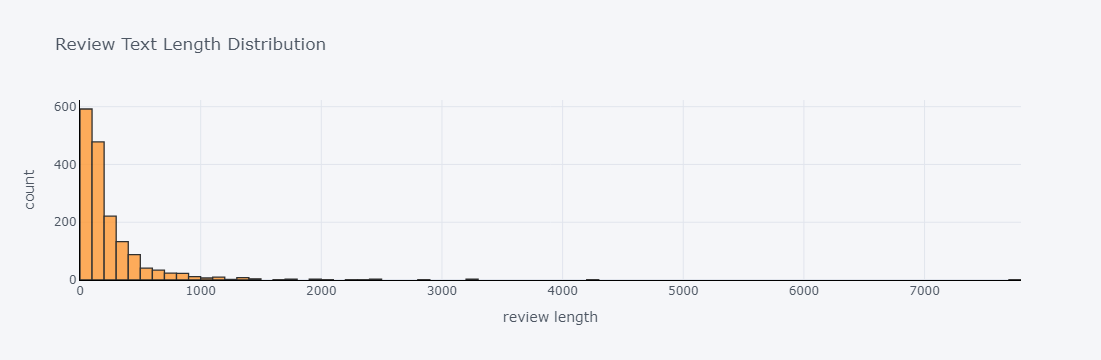

In [23]:
process_reviews['review_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='review length',
    linecolor='black',
    yTitle='count',
    title='Review Text Length Distribution')

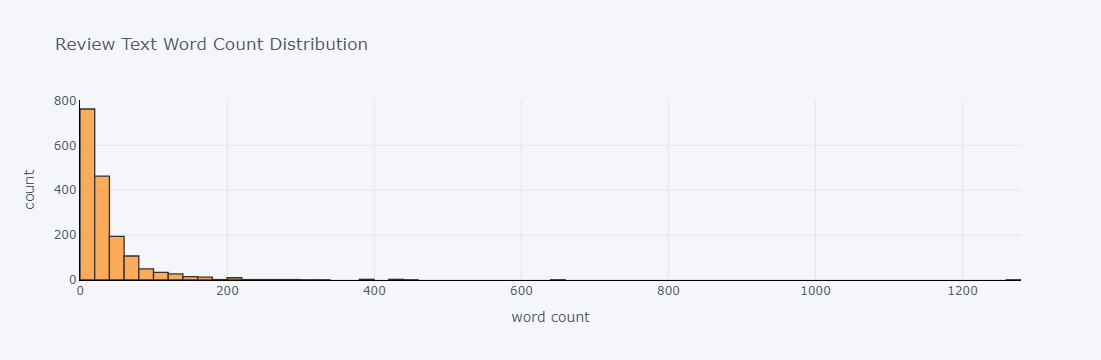

In [24]:
process_reviews['word_count'].iplot(
    kind='hist',
    bins=100,
    xTitle='word count',
    linecolor='black',
    yTitle='count',
    title='Review Text Word Count Distribution')

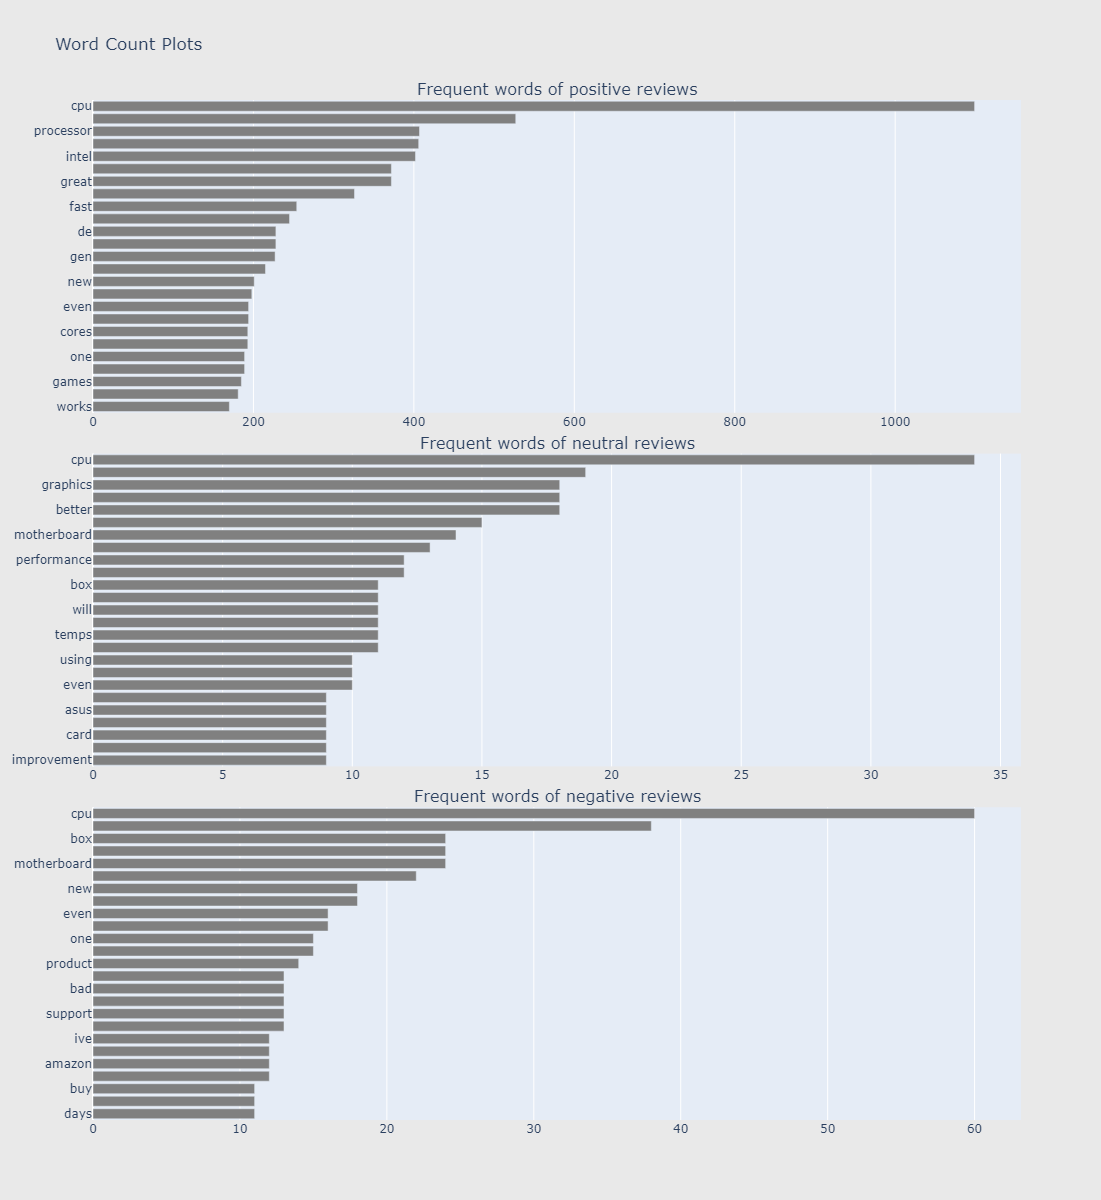

In [25]:
#Filtering data
review_pos = process_reviews[process_reviews["Sentiment"]=='Positive'].dropna()
review_neu = process_reviews[process_reviews["Sentiment"]=='Neutral'].dropna()
review_neg = process_reviews[process_reviews["Sentiment"]=='Negative'].dropna()

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
if not fd_sorted.empty:
    fd_sorted.columns = ["word", "wordcount"]
# Proceed with the plotting or other operations if the DataFrame is not empty
if not fd_sorted.empty:
    trace0 = horizontal_bar_chart(fd_sorted.head(25), 'grey')
else:
    print("The DataFrame is empty. No data to plot.")


## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
if not fd_sorted.empty:
    fd_sorted.columns = ["word", "wordcount"]
# Proceed with the plotting or other operations if the DataFrame is not empty
if not fd_sorted.empty:
    trace1 = horizontal_bar_chart(fd_sorted.head(25), 'grey')
else:
    print("The DataFrame is empty. No data to plot.")

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
if not fd_sorted.empty:
    fd_sorted.columns = ["word", "wordcount"]
# Proceed with the plotting or other operations if the DataFrame is not empty
if not fd_sorted.empty:
    trace2 = horizontal_bar_chart(fd_sorted.head(25), 'grey')
else:
    print("The DataFrame is empty. No data to plot.")


# Creating two subplots
fig = tools.make_subplots(rows=3, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of positive reviews", "Frequent words of neutral reviews",
                                          "Frequent words of negative reviews"])
fig.append_trace(trace0, 1, 1)
try:
    fig.append_trace(trace1, 2, 1)
except:
    pass
fig.append_trace(trace2, 3, 1)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
iplot(fig, filename='word-plots')

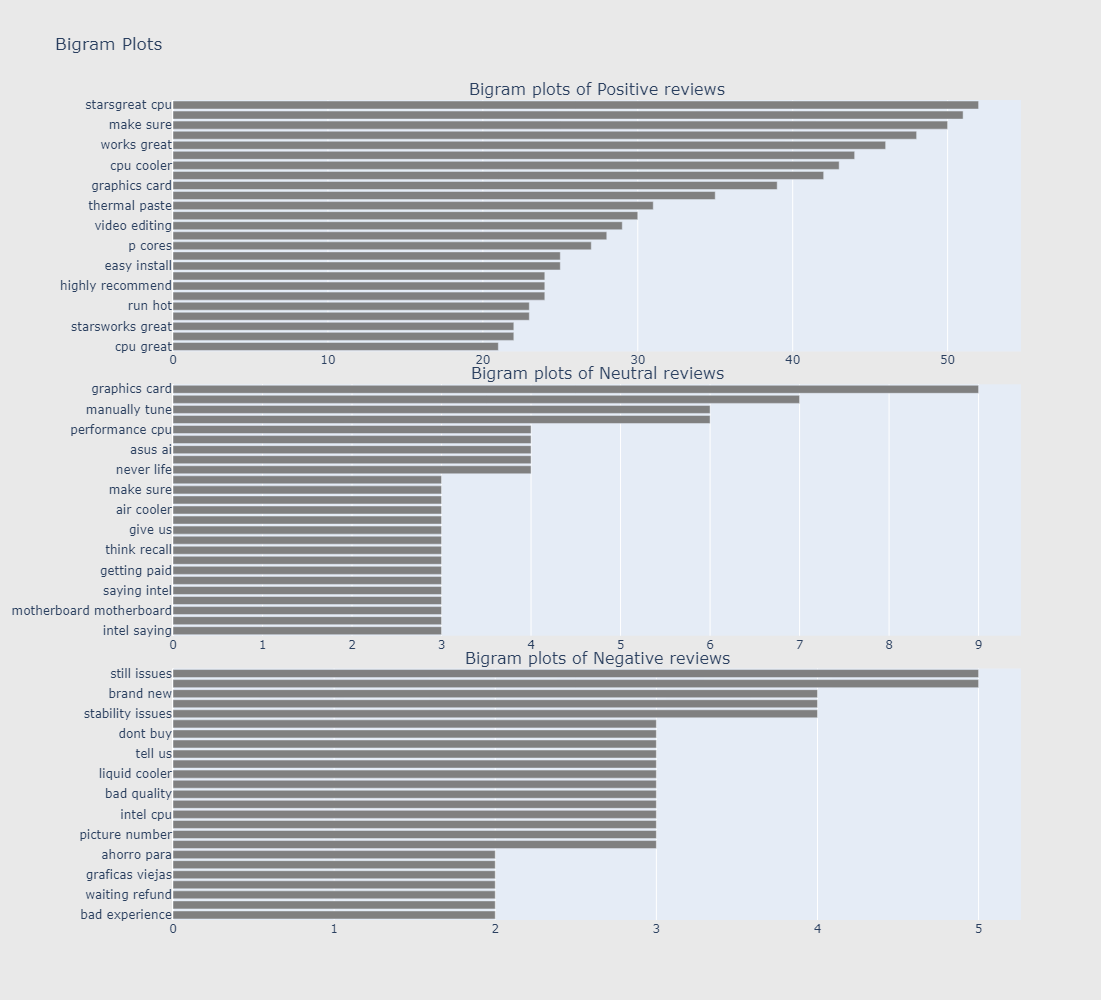

In [26]:
## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
if not fd_sorted.empty:
    fd_sorted.columns = ["word", "wordcount"]
# Proceed with the plotting or other operations if the DataFrame is not empty
if not fd_sorted.empty:
    trace0 = horizontal_bar_chart(fd_sorted.head(25), 'grey')
else:
    print("The DataFrame is empty. No data to plot.")

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["reviews"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
if not fd_sorted.empty:
    fd_sorted.columns = ["word", "wordcount"]
# Proceed with the plotting or other operations if the DataFrame is not empty
if not fd_sorted.empty:
    trace1 = horizontal_bar_chart(fd_sorted.head(25), 'grey')
else:
    print("The DataFrame is empty. No data to plot.")

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
if not fd_sorted.empty:
    fd_sorted.columns = ["word", "wordcount"]
# Proceed with the plotting or other operations if the DataFrame is not empty
if not fd_sorted.empty:
    trace2 = horizontal_bar_chart(fd_sorted.head(25), 'grey')
else:
    print("The DataFrame is empty. No data to plot.")



# Creating two subplots
fig = tools.make_subplots(rows=3, cols=1, vertical_spacing=0.04,horizontal_spacing=0.25,
                          subplot_titles=["Bigram plots of Positive reviews", 
                                          "Bigram plots of Neutral reviews",
                                          "Bigram plots of Negative reviews"
                                          ])
fig.append_trace(trace0, 1, 1)
try:
    fig.append_trace(trace1, 2, 1)
except:
    pass
fig.append_trace(trace2, 3, 1)


fig['layout'].update(height=1000, width=800, paper_bgcolor='rgb(233,233,233)', title="Bigram Plots")
iplot(fig, filename='word-plots')

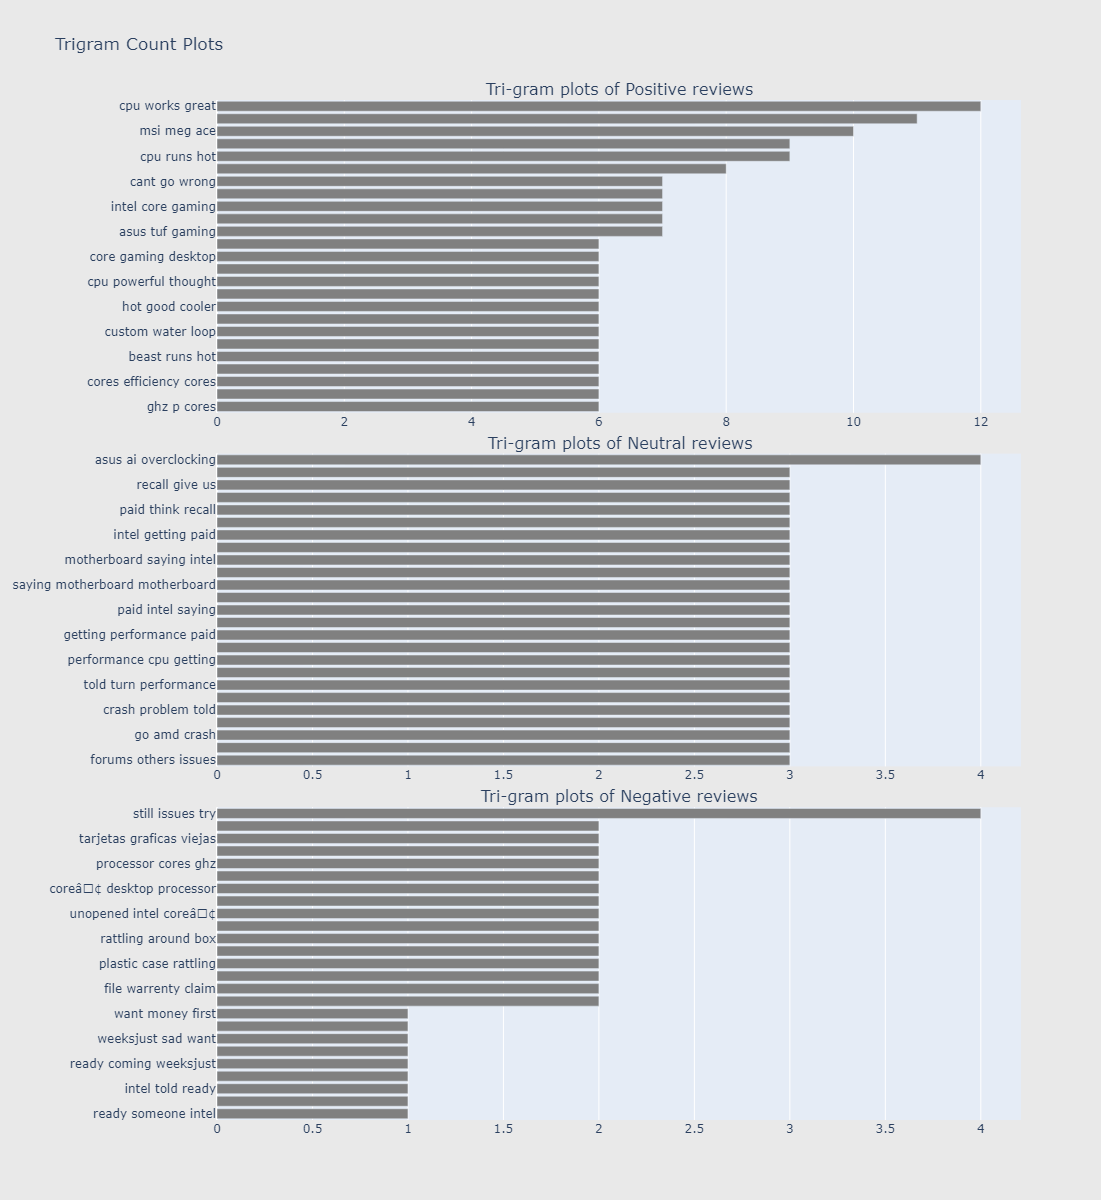

In [27]:
## Get the bar chart from positive reviews ##
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
if not fd_sorted.empty:
    fd_sorted.columns = ["word", "wordcount"]
# Proceed with the plotting or other operations if the DataFrame is not empty
if not fd_sorted.empty:
    trace0 = horizontal_bar_chart(fd_sorted.head(25), 'grey')
else:
    print("The DataFrame is empty. No data to plot.")
## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["reviews"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
if not fd_sorted.empty:
    fd_sorted.columns = ["word", "wordcount"]
# Proceed with the plotting or other operations if the DataFrame is not empty
if not fd_sorted.empty:
    trace1 = horizontal_bar_chart(fd_sorted.head(25), 'grey')
else:
    print("The DataFrame is empty. No data to plot.")
## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
if not fd_sorted.empty:
    fd_sorted.columns = ["word", "wordcount"]
# Proceed with the plotting or other operations if the DataFrame is not empty
if not fd_sorted.empty:
    trace2 = horizontal_bar_chart(fd_sorted.head(25), 'grey')
else:
    print("The DataFrame is empty. No data to plot.")




# Creating two subplots
fig = tools.make_subplots(rows=3, cols=1, vertical_spacing=0.04, horizontal_spacing=0.05,
                          subplot_titles=["Tri-gram plots of Positive reviews", 
                                          "Tri-gram plots of Neutral reviews",
                                          "Tri-gram plots of Negative reviews"])
fig.append_trace(trace0, 1, 1)
try:
    fig.append_trace(trace1, 2, 1)
except:
    pass
fig.append_trace(trace2, 3, 1)
fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
iplot(fig, filename='word-plots')

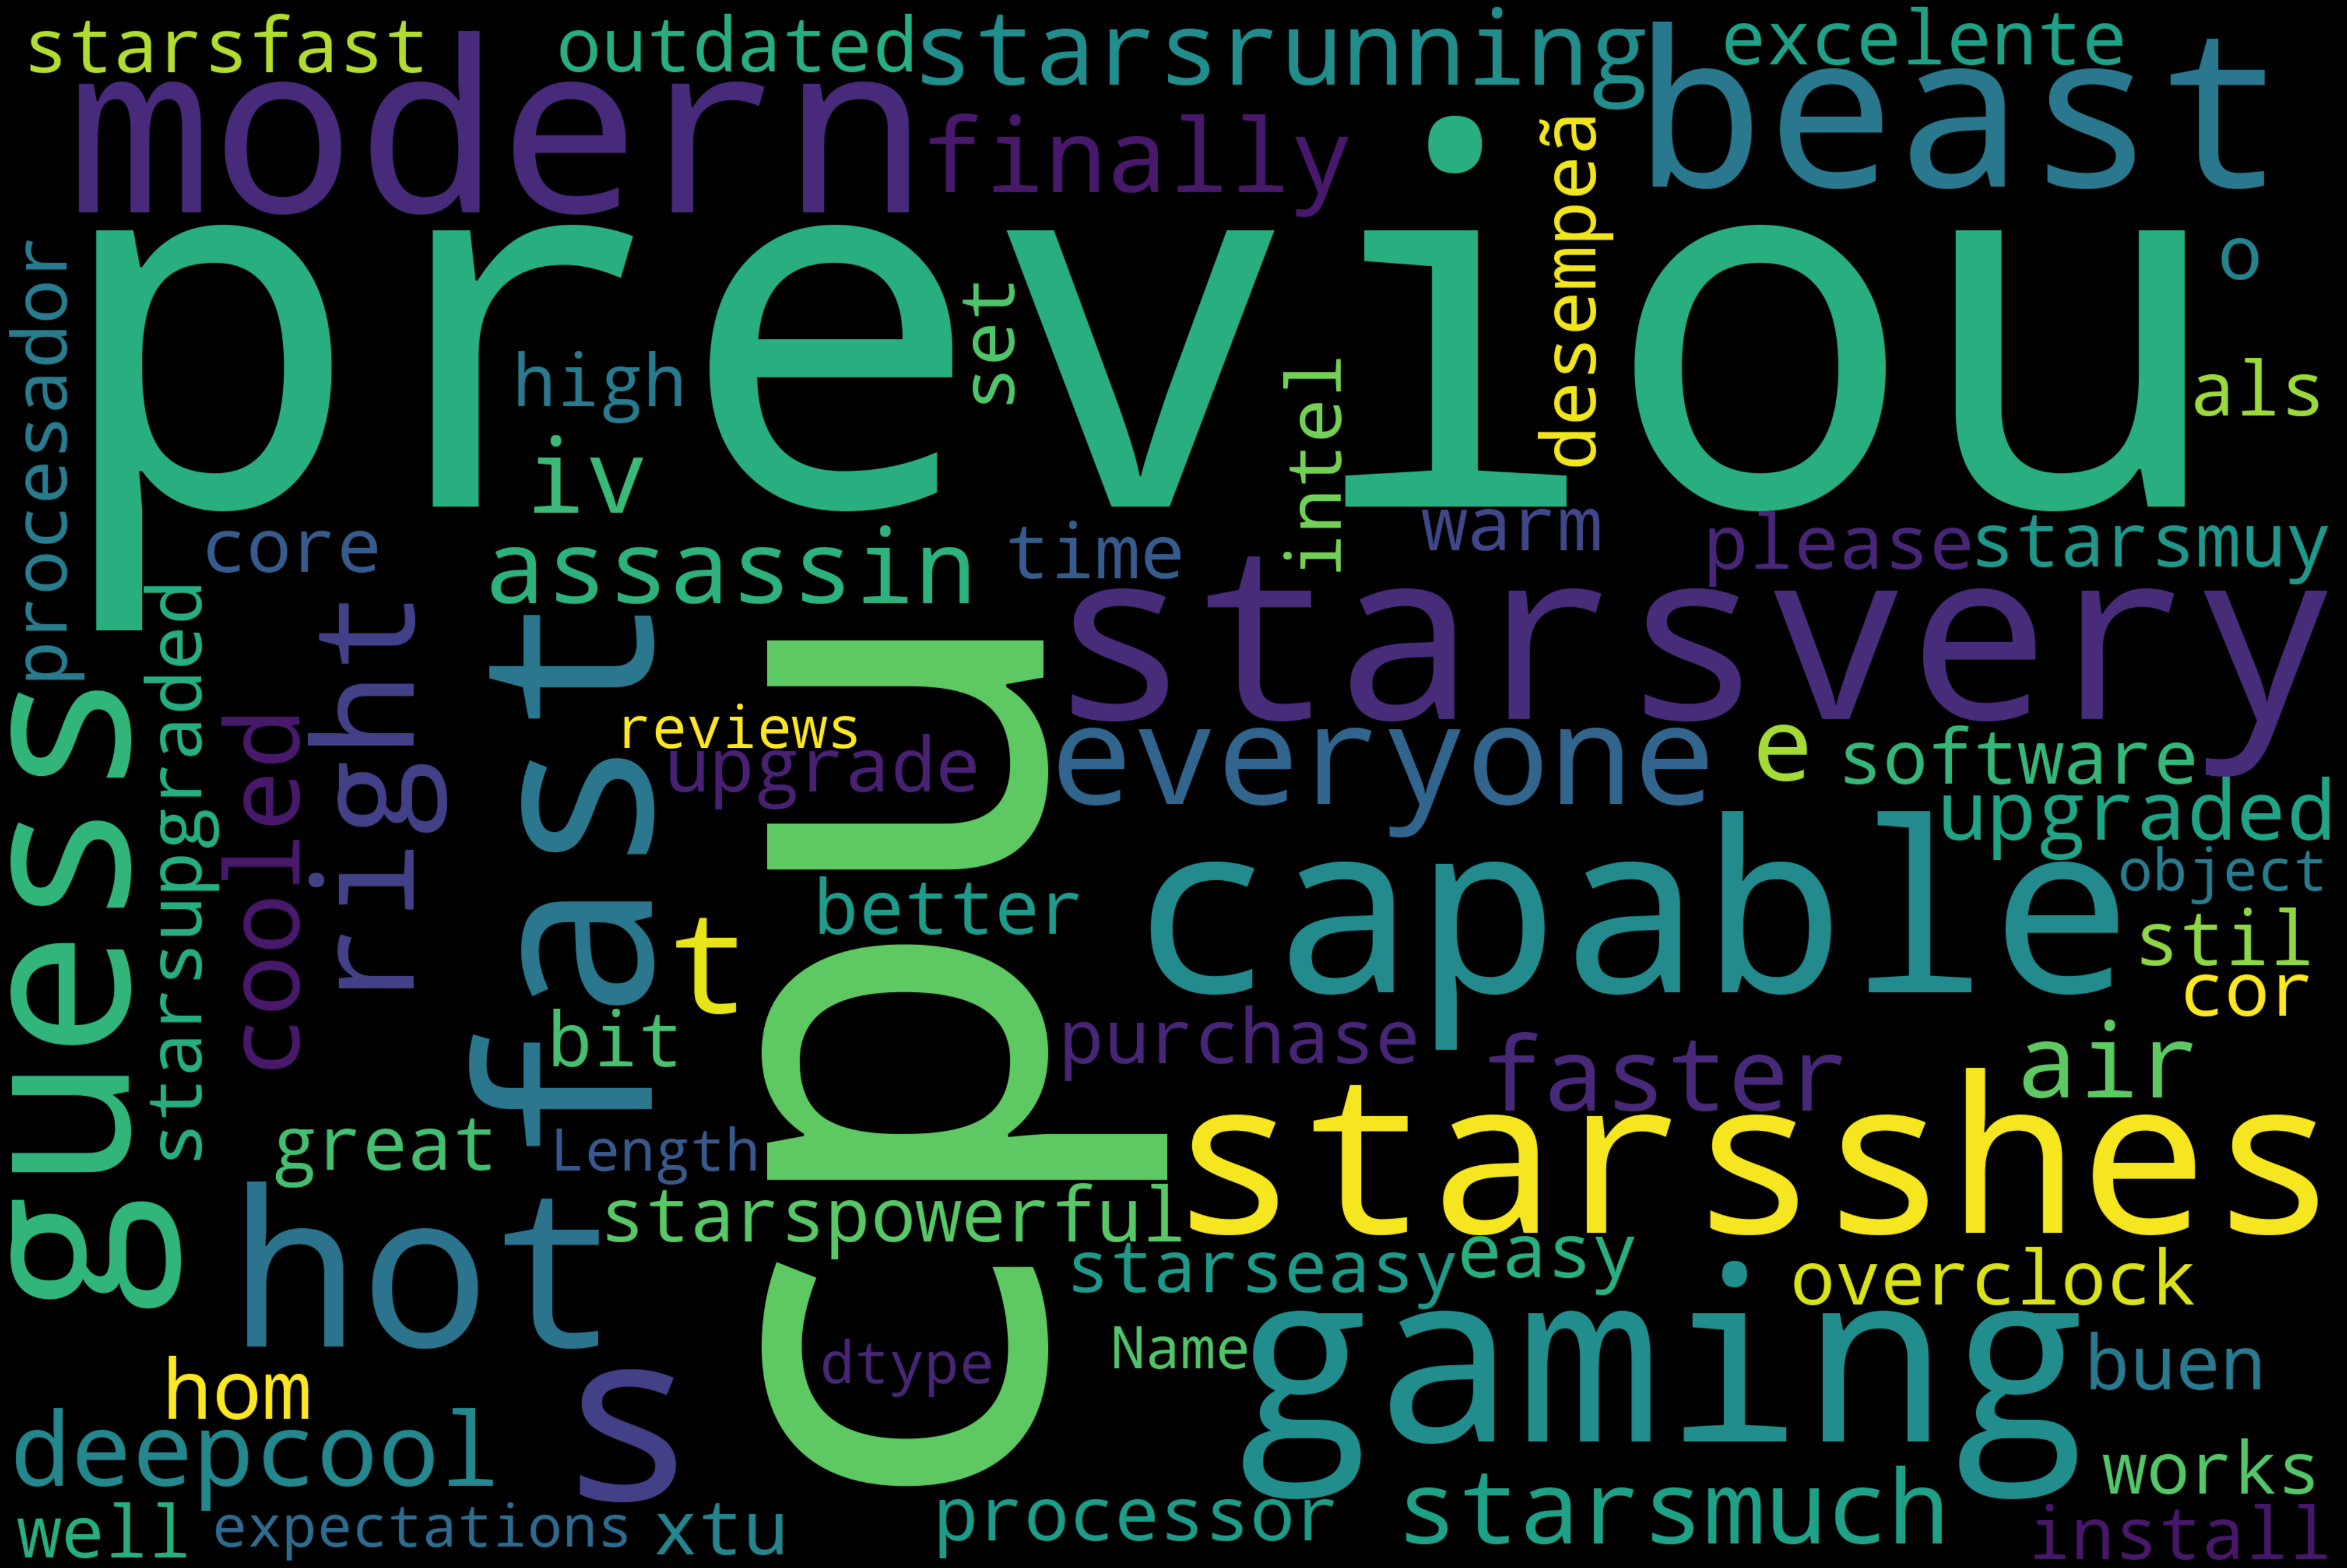

In [28]:
text = review_pos["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

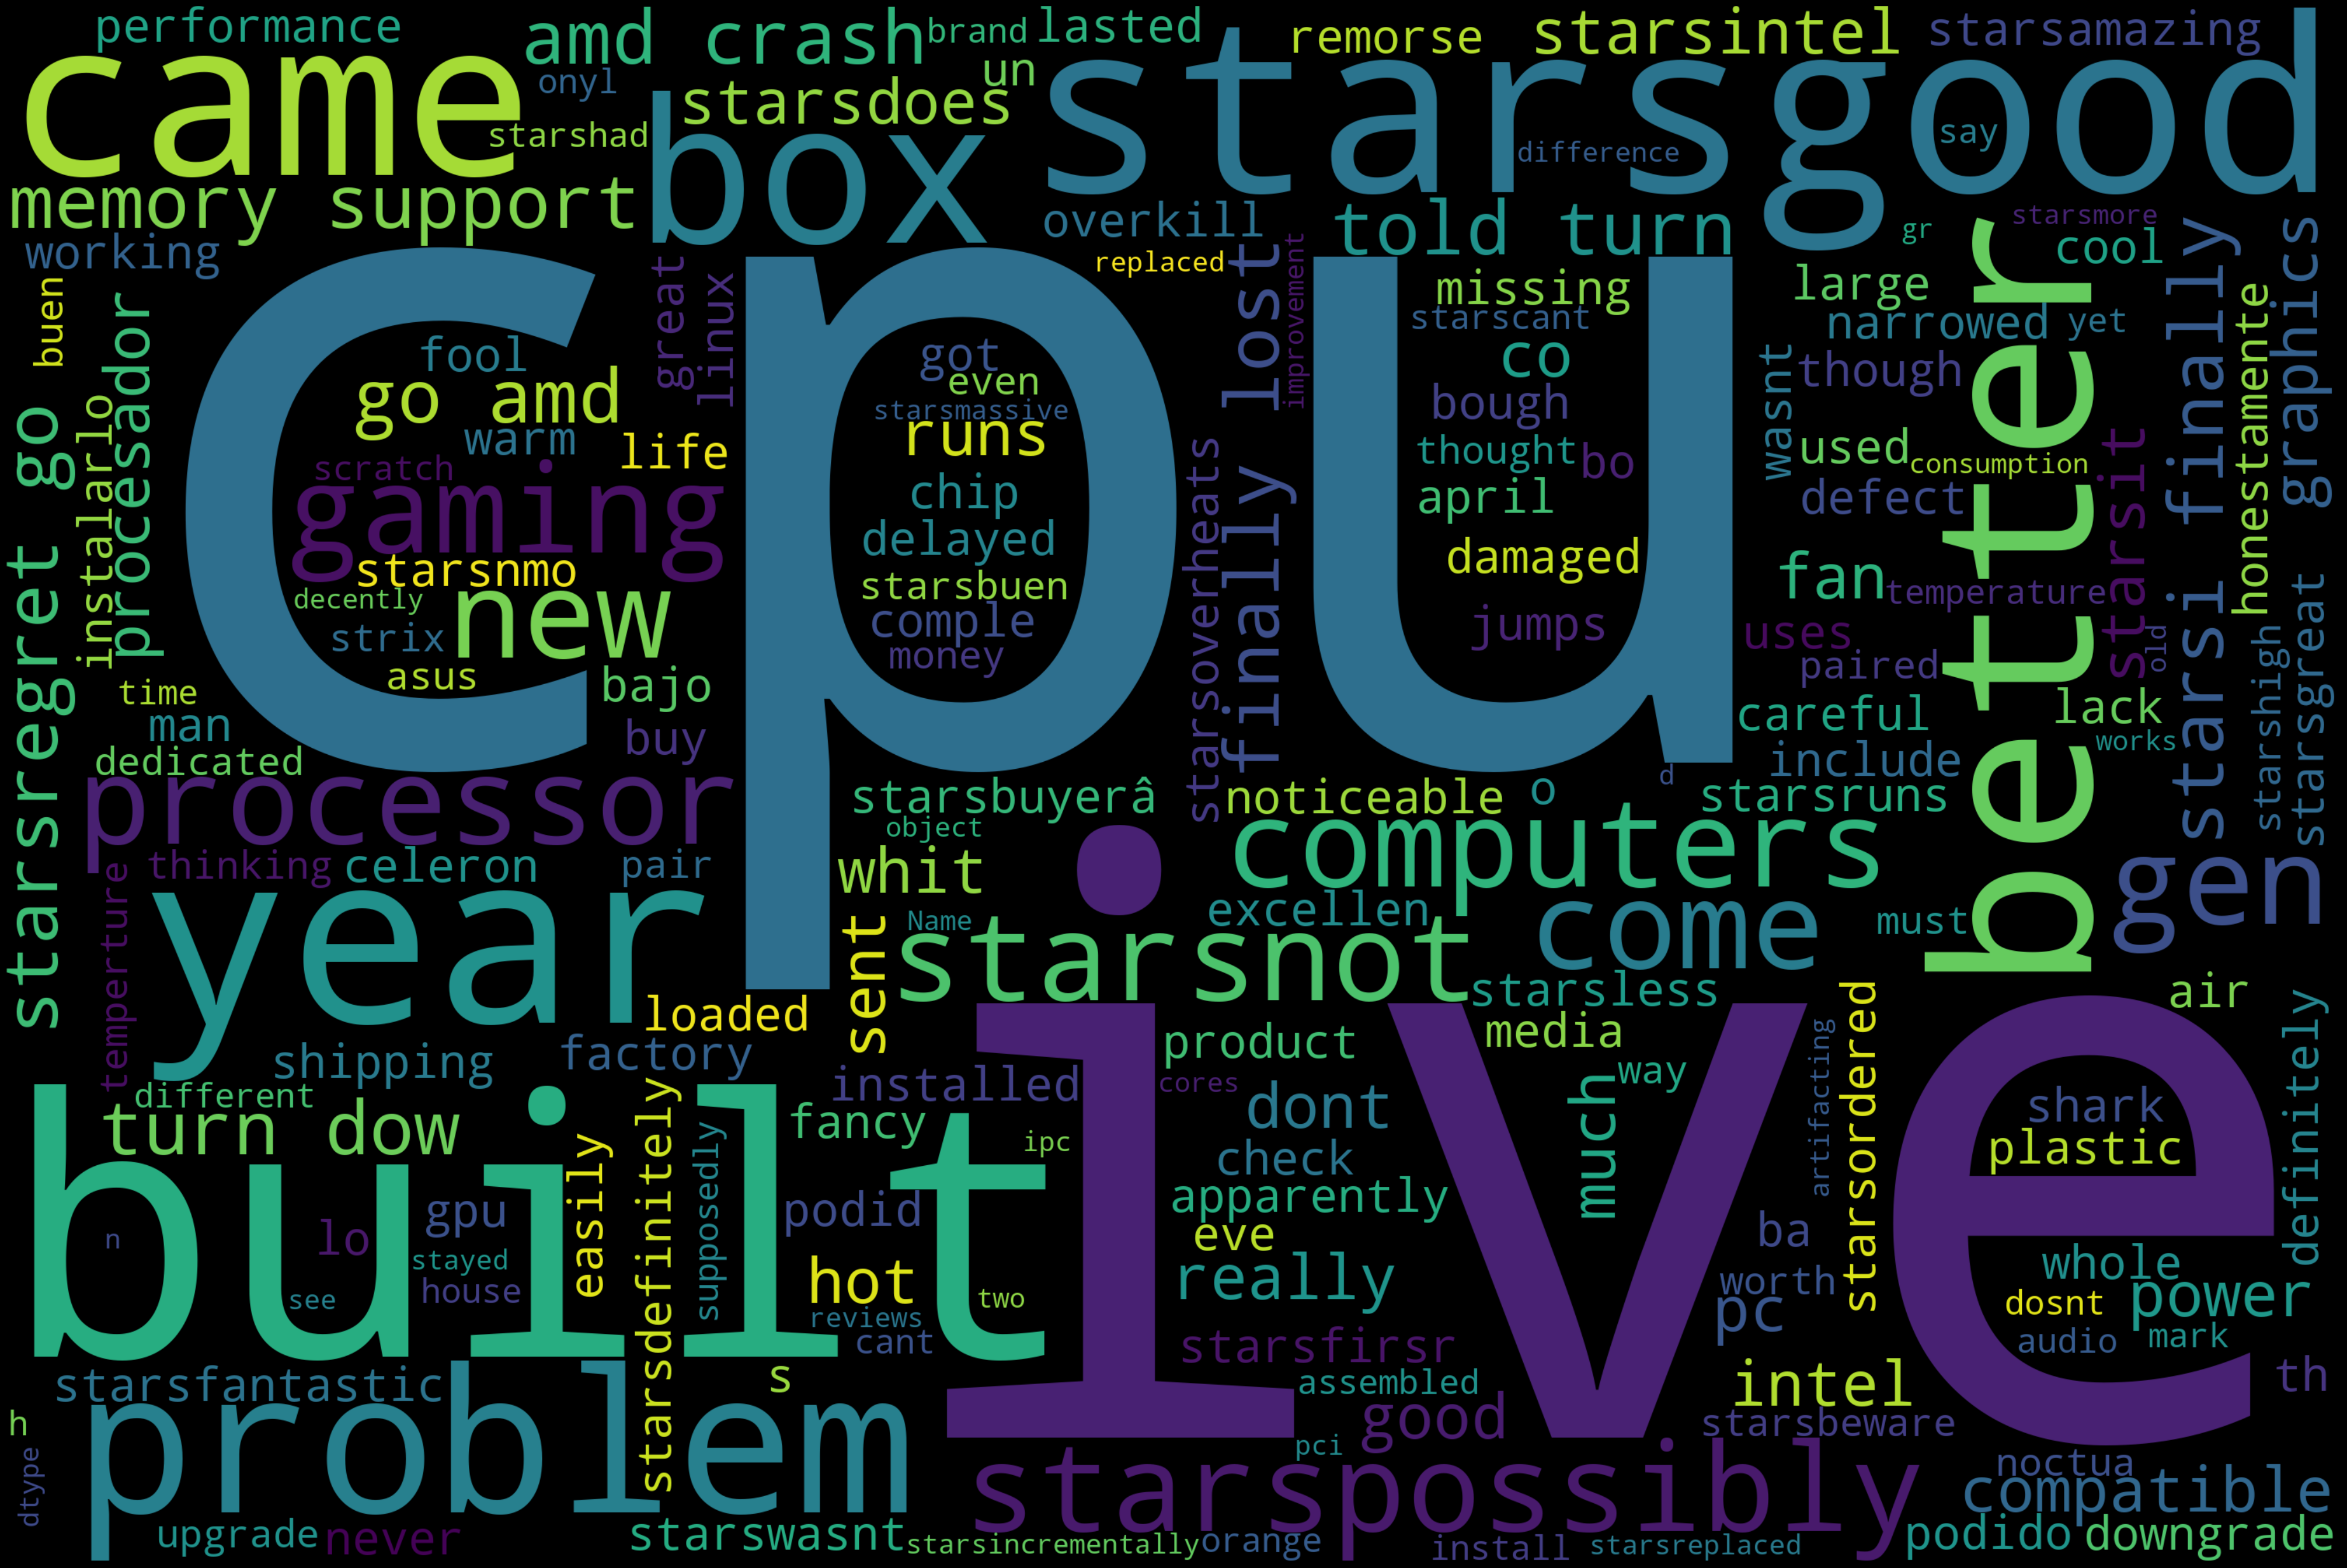

In [29]:
text = review_neu["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

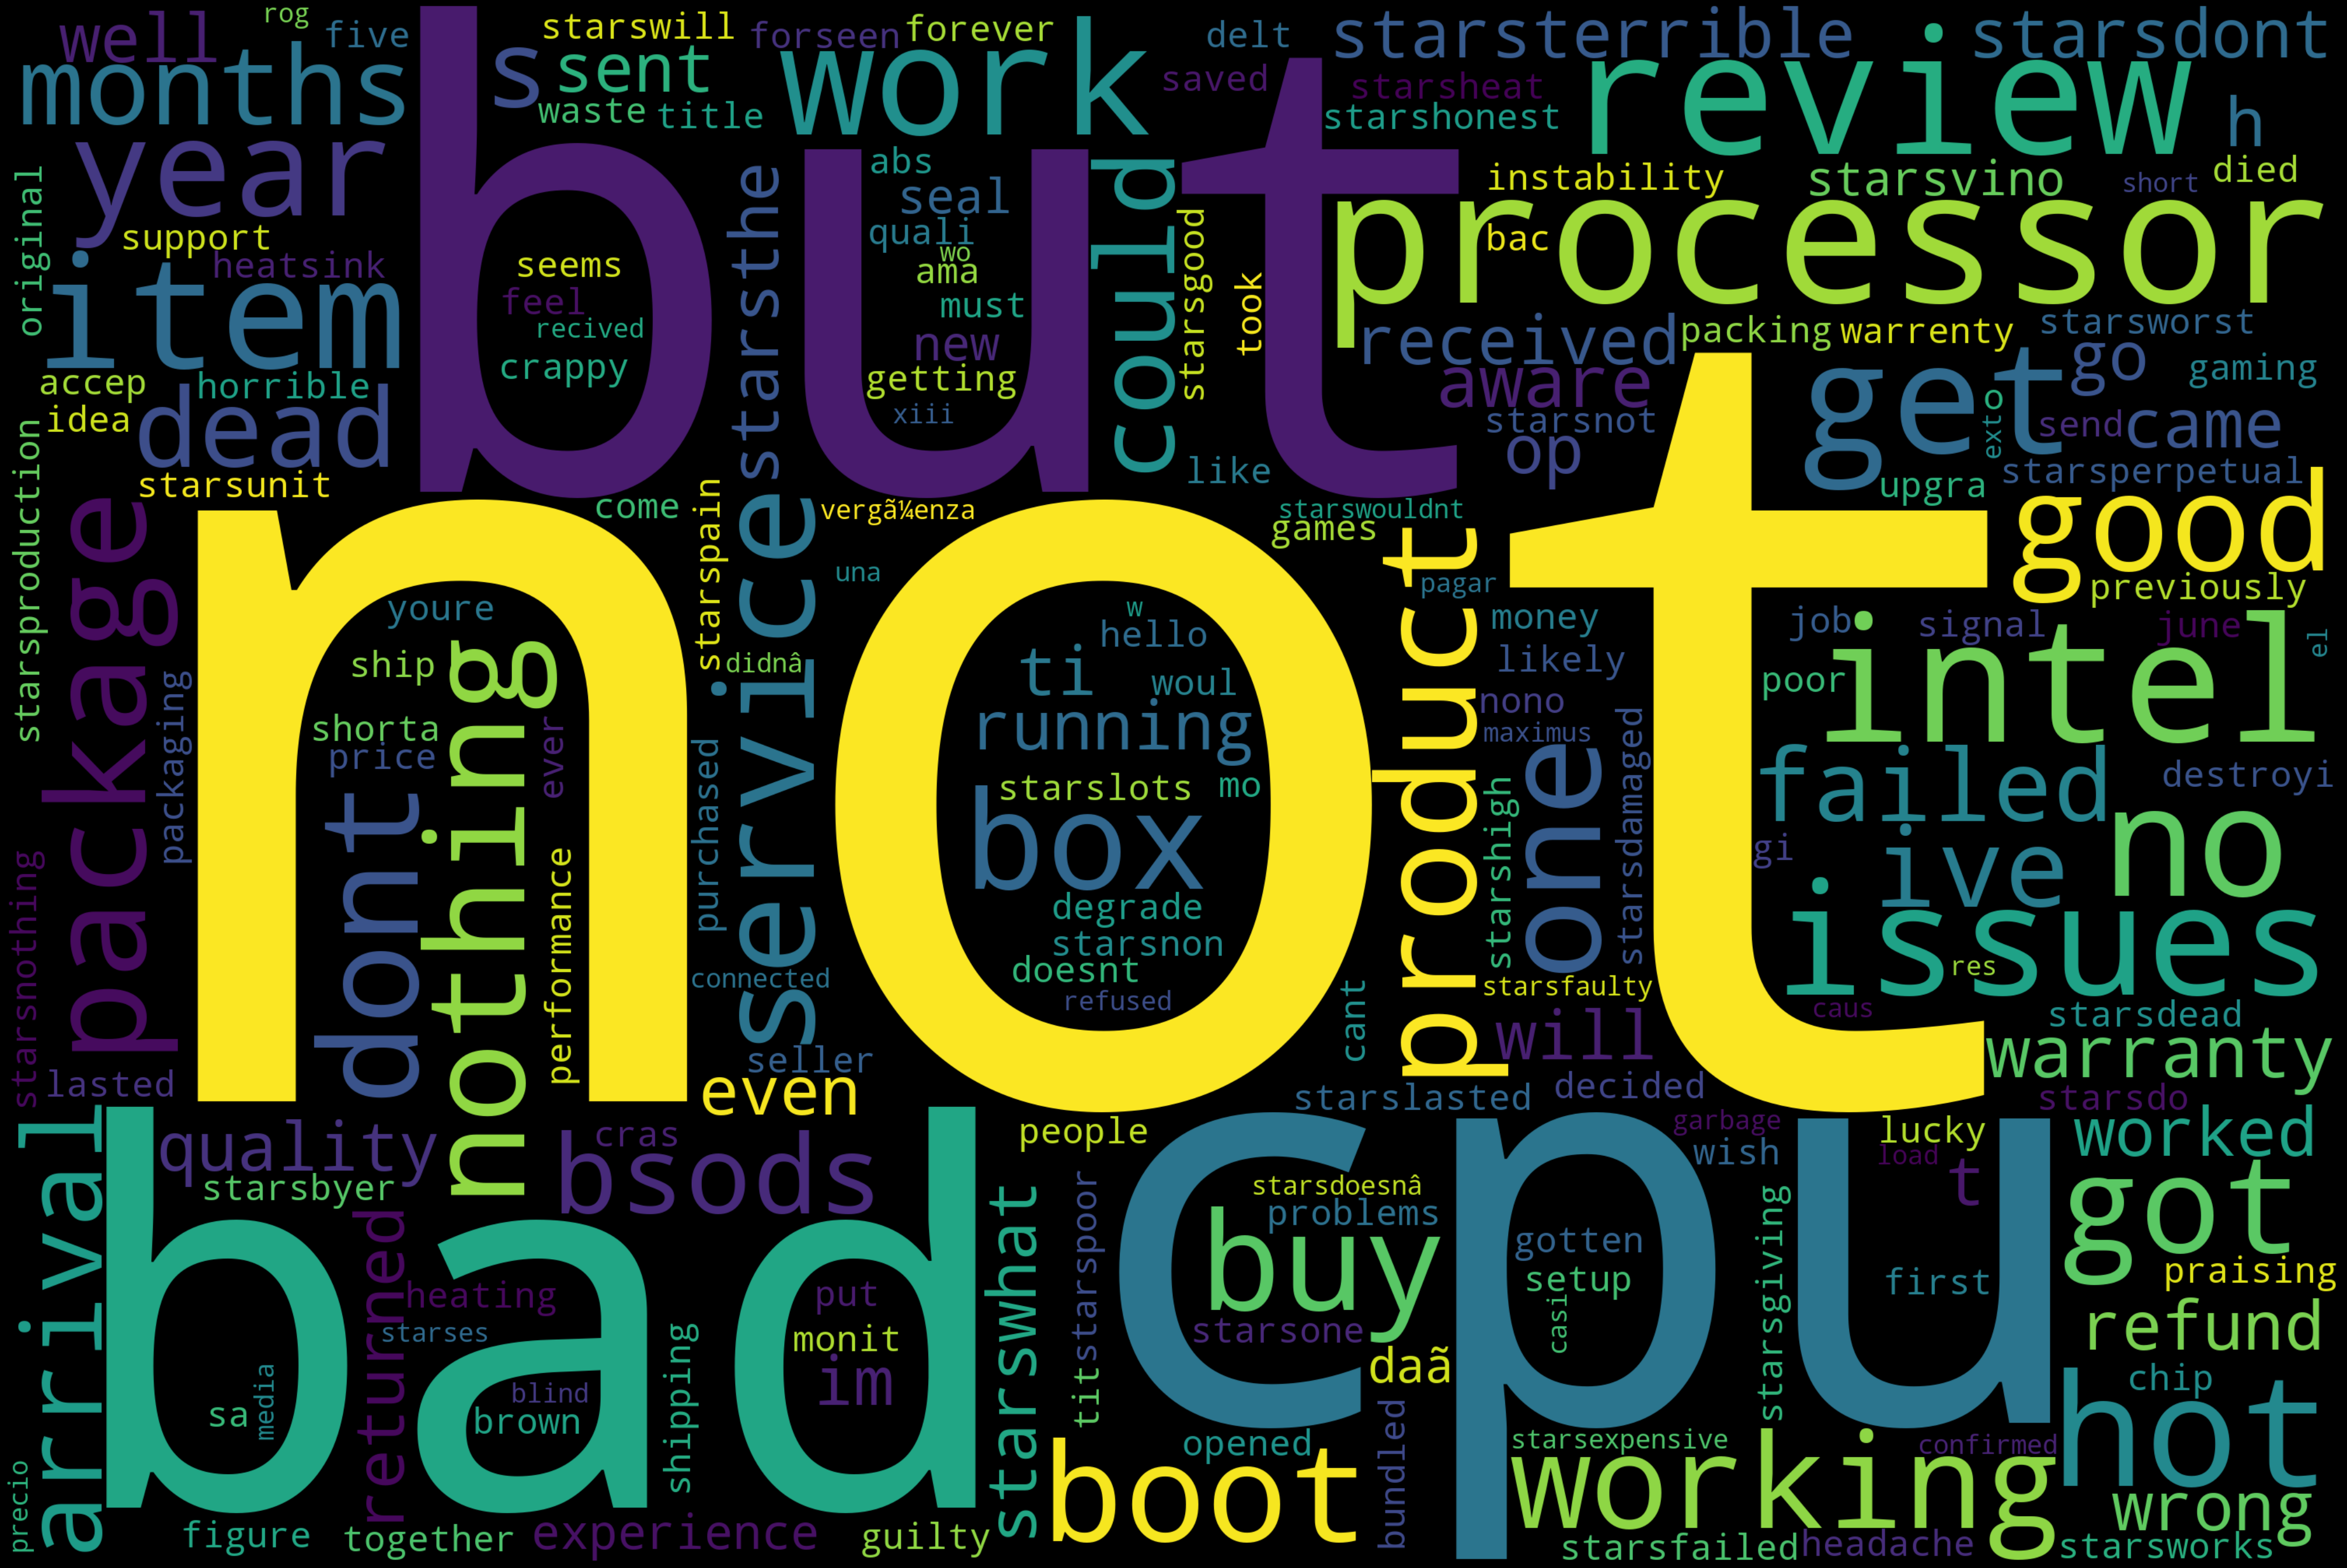

In [30]:
text = review_neg["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = stop_words).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [31]:
#calling the label encoder function
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'sentiment'. 
process_reviews['Sentiment']= label_encoder.fit_transform(process_reviews['Sentiment']) 
  
process_reviews['Sentiment'].unique() 

array([3, 1, 2, 0])

In [32]:
process_reviews['Sentiment'].value_counts()

Sentiment
3    1455
2     139
0      58
1      44
Name: count, dtype: int64

In [33]:
#Extracting 'reviews' for processing
review_features=process_reviews.copy()
review_features=review_features[['reviews']].reset_index(drop=True)
review_features.head()

reviews
0  starsvery fast its capable modern gaming with...
1  starsshes beast but hot guess everyone right t...
2  starsrunning air cooled deepcool assassin iv e...
3  starsmuch faster previous finally upgraded hom...
4  starspowerful but warm purchase cpu please als...

In [34]:
#Performing stemming on the review dataframe
ps = PorterStemmer()

#splitting and adding the stemmed words except stopwords
corpus = []
for i in range(0, len(review_features)):
    review = re.sub('[^a-zA-Z]', ' ', review_features['reviews'][i])
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stop_words]
    review = ' '.join(review)
    corpus.append(review) 

In [35]:
corpus[3]

'starsmuch faster previou final upgrad home workstat went new incred fast davinci resolv video project file render old setup took minut complet render new exact file export took minut almost speed increas also speed footag resolv old cpu could not play back smoothli would jump chug like crazi new play back sped no problem actual see look without export entir video clip see playback retim footag smoothli applic open u p much faster but could due nvme system drive much faster previou version nvme old build one thing not like new cpu number pci lane get wont issu peopl but old cpu lane allow run gpu time ye need use gpu render softwar use gpu one system one licens everi addit gpu speed render time lot render sim new cpu run gpu run caus share leav full lane system drive not deal breaker increas speed overal well worth one thing everybodi awar new intel chip p core e core someth old cpu not ecor sever impact certain softwar perform boot new machin tri ableton daw first time expect happi pe

In [36]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(2,2))
# TF-IDF feature matrix
X= tfidf_vectorizer.fit_transform(review_features['reviews'])

In [37]:
X.shape

(1696, 5000)

In [38]:
#Getting the target variable(encoded)
y=process_reviews['Sentiment']

In [39]:
print(f'Original dataset shape : {Counter(y)}')

smote = BorderlineSMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
print(f'Resampled dataset shape {Counter(y_res)}')

Original dataset shape : Counter({3: 1455, 2: 139, 0: 58, 1: 44})
Resampled dataset shape Counter({3: 1455, 1: 1455, 2: 1455, 0: 1455})


In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.25, random_state=0)

In [41]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [42]:
#creating the objects
logreg_cv = LogisticRegression(random_state=0)
dt_cv=DecisionTreeClassifier()
knn_cv=KNeighborsClassifier()
svc_cv=SVC()
nb_cv=BernoulliNB()
cv_dict = {0: 'Logistic Regression', 1: 'Decision Tree',2:'KNN',3:'SVC',4:'Naive Bayes'}
cv_models=[logreg_cv,dt_cv,knn_cv,svc_cv,nb_cv]


for i,model in enumerate(cv_models):
    print("{} Test Accuracy: {}".format(cv_dict[i],cross_val_score(model, X, y, cv=10, scoring ='accuracy').mean()))

Logistic Regression Test Accuracy: 0.8614410024364776
Decision Tree Test Accuracy: 0.8395649147232858
KNN Test Accuracy: 0.6632335537765401
SVC Test Accuracy: 0.8732196310476853
Naive Bayes Test Accuracy: 0.784368256178211


In [43]:
param_grid = {'C': np.logspace(-4, 4, 50),
             'penalty':['l1', 'l2']}
clf = GridSearchCV(LogisticRegression(random_state=0), param_grid,cv=5, verbose=0,n_jobs=-1)
best_model = clf.fit(X_train,y_train)
print(best_model.best_estimator_)
print("The mean accuracy of the model is:",best_model.score(X_test,y_test))

LogisticRegression(C=10000.0, random_state=0)
The mean accuracy of the model is: 0.9106529209621993


In [44]:
logreg = LogisticRegression(C=10000.0, random_state=0)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.91


Confusion matrix, without normalization


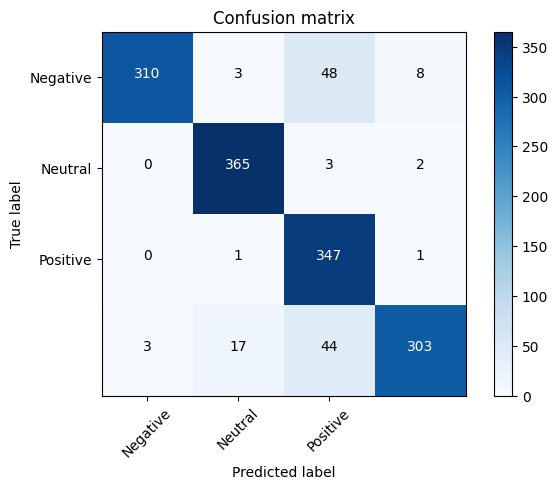

In [45]:
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['Negative','Neutral','Positive'])

In [46]:
print("Classification Report:\n",classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91       369
           1       0.95      0.99      0.97       370
           2       0.79      0.99      0.88       349
           3       0.96      0.83      0.89       367

    accuracy                           0.91      1455
   macro avg       0.92      0.91      0.91      1455
weighted avg       0.92      0.91      0.91      1455



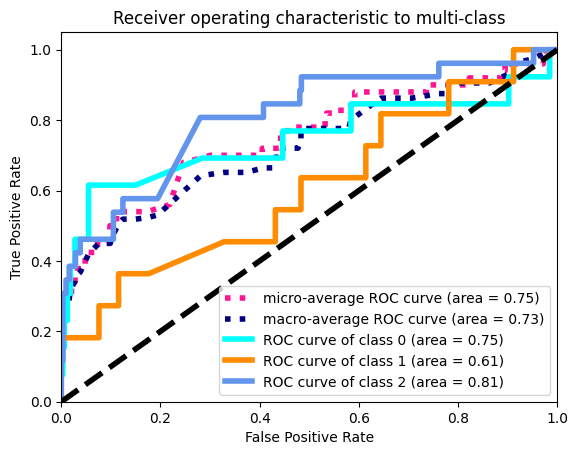

In [47]:
#Binarizing the target feature
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

#Train-Test split(80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                    random_state=0)

#OneVsRestClassifier
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=10))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

#Computing TPR and FPR
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
# aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=4,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()